In [1]:
# 載入套件
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

from wordcloud import WordCloud # pip install wordcloud
import matplotlib.pyplot as plt

# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### 資料前處理
用 nltk 套件做斷句、斷詞、stemming

In [3]:
maildata = pd.read_csv("Phishing_Email.csv")

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# 斷句
maildata = maildata.assign(sentence = maildata['Email Text'].astype(str).apply(nltk.sent_tokenize)).explode('sentence').reset_index(drop=True)

# 刪除標點符號/數字/換行符號
maildata["sentence"] = maildata["sentence"].apply(lambda x: re.sub(r'[^\w\s]','', str(x)))  #只留下英文字母和空格(包含換行符號)
maildata['sentence'] = maildata["sentence"].str.replace(r'[\d]+', '', regex=True).astype(str) #去除數字
maildata["sentence"] = maildata["sentence"].apply(lambda x: re.sub(r'[\n_-]+',' ', x)) #將換行符號替換成空格

# 去除空值
# dataset 有些郵件是 empty
# 經過 nltk 套件會有些東西變 nan
maildata = maildata[maildata["sentence"] != "empty"]
maildata = maildata[maildata["sentence"] != "nan"]

# 斷詞
token_df = maildata.assign(token = maildata['sentence'].apply(nltk.word_tokenize)).explode('token').reset_index(drop=True)

# 轉成小寫
lowerWord_df = token_df.assign(word = token_df['token'].str.lower())

In [6]:
# stemming
# porter = PorterStemmer()
# mails_df = lowerWord_df.assign(stem_token = lowerWord_df['word'].astype(str).apply(porter.stem)).reset_index(drop=True)

# lemmatization
lm = WordNetLemmatizer()
mails_df = lowerWord_df.assign(stem_token = lowerWord_df['word'].astype(str).apply(lm.lemmatize)).reset_index(drop=True)


In [7]:
# 將不必要的欄位 以及 nan 刪掉
tidy_mails_df = mails_df.drop(columns=["token", "word"])
tidy_mails_df = tidy_mails_df.rename(columns={"Unnamed: 0":"index", "stem_token":"word"})
tidy_mails_df = tidy_mails_df[tidy_mails_df['word'] != 'nan']

In [8]:
def is_single_english_letter(word):
    # 使用正則表達式匹配僅包含一個英文字母的字符串
    #return bool(re.fullmatch(r'[a-zA-Z]', word))
    return len(word) <= 1

tidy_mails_df = tidy_mails_df[~tidy_mails_df['word'].apply(is_single_english_letter)]

In [9]:
tidy_mails_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6836675 entries, 0 to 7318687
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   index       int64 
 1   Email Text  object
 2   Email Type  object
 3   sentence    object
 4   word        object
dtypes: int64(1), object(4)
memory usage: 313.0+ MB


### 移除停用字

In [10]:
# 初次使用需要安裝nltk中的停用字資源
nltk.download('stopwords')
# 使用nltk的stop_words
stops = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# 手動加入停用字
newStops = ['email','com','wa','ect','one','would','could','may','can','de','also','edu','ha']
stops.extend(newStops)

In [12]:
noStop_df = tidy_mails_df[~tidy_mails_df['word'].isin(stops)]
noStop_df

,index,Email Text,Email Type,sentence,word
1,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,disc
2,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,uniformitarianism
4,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,sex
5,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,lang
6,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,dick
...,...,...,...,...,...
7318683,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,team
7318684,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,kind
7318685,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,regard
7318686,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,kuldeep


以上為資料前處理的部分

In [13]:
tmp = noStop_df.groupby(['index'], as_index = False).agg({'word': lambda x: " ".join(x)})
tmp.head()

,index,word
0,0,disc uniformitarianism sex lang dick hudson ob...
1,1,side galicismos galicismo spanish term name im...
2,2,equistar deal ticket still available assist ro...
3,3,hello hot lil horny toy dream open minded pers...
4,4,software incredibly low price lower drapery se...


In [14]:
new_df = pd.read_csv("Phishing_Email.csv")
new_df = new_df.rename(columns={"Unnamed: 0":"index"})
new_df.head()

,index,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [15]:
new_df = new_df.merge(tmp, on = ['index'])
new_df.head()

,index,Email Text,Email Type,word
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism sex lang dick hudson ob...
1,1,the other side of * galicismos * * galicismo *...,Safe Email,side galicismos galicismo spanish term name im...
2,2,re : equistar deal tickets are you still avail...,Safe Email,equistar deal ticket still available assist ro...
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,hello hot lil horny toy dream open minded pers...
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email,software incredibly low price lower drapery se...


In [16]:
label_dict = {'Safe Email': 0, 'Phishing Email': 1}
new_df['Email Type'] = new_df['Email Type'].map(label_dict)
new_df.head()

,index,Email Text,Email Type,word
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0,disc uniformitarianism sex lang dick hudson ob...
1,1,the other side of * galicismos * * galicismo *...,0,side galicismos galicismo spanish term name im...
2,2,re : equistar deal tickets are you still avail...,0,equistar deal ticket still available assist ro...
3,3,\nHello I am your hot lil horny toy.\n I am...,1,hello hot lil horny toy dream open minded pers...
4,4,software at incredibly low prices ( 86 % lower...,1,software incredibly low price lower drapery se...


以上為將資料處理成可以餵進TfidfVectorizer的格式

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)
%matplotlib inline

In [18]:
seed = 1126

In [19]:
X = new_df.word
y = new_df['Email Type']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

### 將資料轉成tf-idf的格式後，訓練random forest

In [21]:
vectorizer = TfidfVectorizer(max_features = 10000, stop_words="english")
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

In [22]:
rf = RandomForestClassifier(random_state = seed)
rf.fit(vec_train, y_train)

RandomForestClassifier(random_state=1126)

In [23]:
y_pred = rf.predict(vec_test)

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, RocCurveDisplay

def plot_confusion_matrix(y_model, y_true, labels):
    cm = confusion_matrix(y_true,y_model,normalize='true')
    fig, ax = plt.subplots(figsize=(7,7))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
    disp.plot(ax=ax, colorbar=False)
    plt.title("Confusion matrix")
#     plt.axis('off')
    plt.grid(False)
    plt.show()

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2190
           1       0.96      0.96      0.96      1430

    accuracy                           0.97      3620
   macro avg       0.97      0.97      0.97      3620
weighted avg       0.97      0.97      0.97      3620



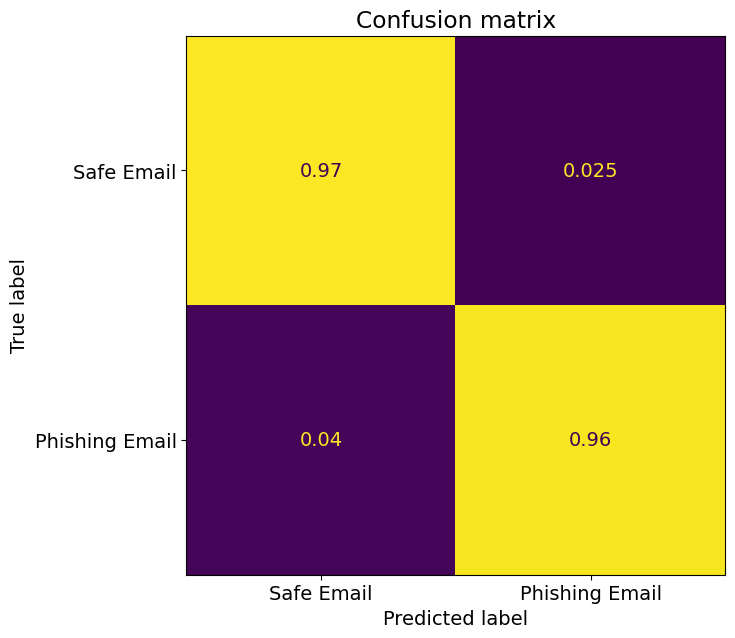

In [27]:
plot_confusion_matrix(y_pred, y_test, label_dict.keys())

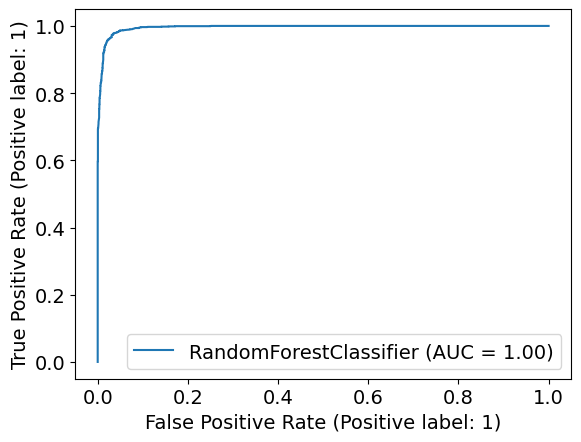

In [28]:
RocCurveDisplay.from_estimator(rf, vec_test, y_test)

f1-score和auc都表現得非常好，令人感到出乎意料之外